# **Test Ground for EWC Calculations**

## **Import libraries**

In [1]:
from copy import deepcopy
import os

import torch
import torch.nn as nn
import torch.autograd as autograd

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as optim

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from dcgan.components.generator import Generator
from dcgan.components.discriminator import Discriminator

# For working with Notebooks
from IPython.display import clear_output

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## **Define EWC-related class and additional functions**

In [3]:
class EWC:
    """
    Class for performing Elastic Weight Consolidation
    Reference link:
        https://discuss.pytorch.org/t/implementation-of-elastic-weight-consolidation-fisher-information-matrix/9309/3 
    """

    def __init__(self, model_anchor):
        self._model_anchor = model_anchor
        self._params_anchor = {n: p for n, p in model_anchor.named_parameters()}
        self._fishers, self._mean_fishers = None, None


    def _calc_fisher(self, likelihood, nsample=1):
        # TODO: Process unused params case
        grads = autograd.grad(likelihood, self._model_anchor.parameters())
        _fishers = [(g**2)/nsample for g in grads]

        param_names = [name for name, _ in self._model_anchor.named_parameters()]
        fs_dict = {n: f for n, f in zip(param_names, _fishers)}

        return fs_dict
    

    def set_fisher(self, likelihood, nsample=1):
        self._fishers = self._calc_fisher(likelihood, nsample=nsample)


    def get_fisher(self): return self._fishers

    
    def calc_ewc(self, model, weight=5e8, batch_size=32):
        params = {n: p for n, p in model.named_parameters()}

        ewc = 0
        for name in self._fishers:
            _ewc = self._fishers[name]*(params[name] - self._params_anchor[name])**2
            ewc += _ewc.sum()
        ewc /= batch_size
        return weight*ewc


def loss_adapt(l_adv, ewc, model, batch_size=32, weight=5e8):
    l_ewc = ewc.calc_ewc(model, weight=weight, batch_size=batch_size)
    return l_adv + l_ewc, l_ewc


def make_image_plot(file_path, generator, examples=25, latent_size=512, dim=(5,5), figsize=(10,10)):
    noise= torch.randn(examples, latent_size).to(device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()
    plt.figure(figsize=figsize)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


    for i in range(generated_images.shape[0]):
        plt.subplot(5, 5, i + 1)
        image = generated_images[i].permute(1,2,0)
        plt.imshow(image,interpolation='nearest',cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(file_path)
    plt.close('all')


def make_train_summary_plot(histories, colors, labels):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(histories[0]) + 1), histories[0], color=colors[0], label=labels[0])
    plt.plot(range(1, len(histories[1]) + 1), histories[1], color=colors[1], label=labels[1])
    plt.title('Generator Loss During Adaptation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    


def generate_folder(generator, folderpath, examples=25, latent_size=512):
    noise= torch.randn(examples, latent_size).to(device)
    with torch.no_grad():
        generated_images = generator(noise).detach().cpu()

    for i in range(generated_images.shape[0]):
        file_name = f"{i}.jpg"
        image = generated_images[i].permute(1,2,0)
        plt.imsave(os.path.join(folderpath, file_name), image.numpy())


def param_diff(model0, model1):
    params0 = {n: p for n, p in model0.named_parameters()}
    params1 = {n: p for n, p in model1.named_parameters()}

    param_diffs = []
    for name in params0:
        dparam = ((params0[name] - params1[name])**2).mean().detach().cpu()
        param_diffs.append(dparam**2)

    return param_diffs

## **Model configuration**

In [4]:
gen_model = Generator()
gen_model.load_state_dict(torch.load('models/epoch140_generator.pth'))
gen_model.to(device)

dis_model = Discriminator()
dis_model.load_state_dict(torch.load('models/epoch140_discriminator.pth'))
dis_model.to(device)

# optimizer_g = optim.Adam(gen_model.parameters(), lr=0.0004, betas=(0.5, 0.999))
# optimizer_d = optim.Adam(dis_model.parameters(), lr=0.0001, betas=(0.5, 0.999))

C:\Users\Admin\AppData\Local\Temp\ipykernel_17932\1345328573.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gen_model.load_state_dict(torch.load('models/epoch140_genera

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
   

## **Set hyperparameters**

In [5]:
batch_size = 16
latent_size = 512
criterion = nn.BCELoss()

## **Adaptation test**

### **Prepare dataloader**

In [6]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),          
    #transforms.Normalize(mean=0.5, std=0.5)  
])

imgpath = "data/adapt_celebA/"
dataset = ImageFolder(root=imgpath, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1, drop_last= True)

print(len(dataloader))

4


### **Compute Fisher information (DO ONLY ONCE BEFORE ADAPTATION)**

>>> likelihood tensor(11.7974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
>>> l_adv tensor(11.7974, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
>>> l_ewc tensor(0., device='cuda:0', grad_fn=<MulBackward0>)
>>> l_adapt tensor(11.7974, device='cuda:0', grad_fn=<AddBackward0>)


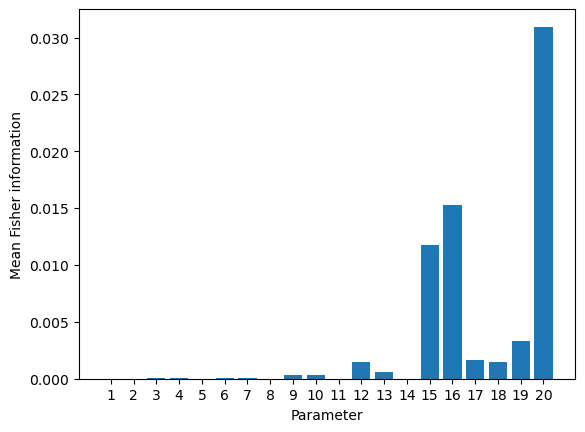

In [7]:
ewc = EWC(gen_model)

# Generate sample input and output
noise = torch.randn(300, latent_size).to(device)
output_d = dis_model(gen_model(noise)).view(-1)
real_label = torch.full((300, ), 0.99, dtype=torch.float).to(device)

# Error between Discriminator output and actual label
likelihood = criterion(output_d, real_label)
print(">>> likelihood", likelihood)

# Compute Fisher information for each parameter
ewc.set_fisher(likelihood, nsample=300)
fishers = ewc.get_fisher()

# Plot mean Fisher information
fisher_vals = [fishers[n].mean().detach().cpu() for n in fishers]
plt.bar(np.arange(len(fisher_vals)) + 1, fisher_vals)
plt.xticks(np.arange(len(fisher_vals)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Fisher information")

# Example value for adversarial loss
# NOTE: Will need to change formula in actual training
l_adv = criterion(output_d, real_label)

generator_new = deepcopy(gen_model)
l_adapt, l_ewc = loss_adapt(l_adv, ewc, generator_new, batch_size=300)

print(">>> l_adv", l_adv)
print(">>> l_ewc", l_ewc)
print(">>> l_adapt", l_adapt)

### **Adapt loop**

In [8]:
g_history = []
ewc_history = []
real_lb = 0.99
fake_lb = 0
num_epochs = 30
regWeight = 5e8

# Model to adapt
adapt_generator = Generator()
adapt_generator.load_state_dict(torch.load('models/epoch140_generator.pth'))
adapt_generator.to(device)
optimizer_g_adapt = optim.Adam(adapt_generator.parameters(), lr=0.0009, betas=(0.5, 0.999))

C:\Users\Admin\AppData\Local\Temp\ipykernel_17932\1541793534.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapt_generator.load_state_dict(torch.load('models/epoch140

Loss_G: 131.9069, EWC: 122.27810668945312


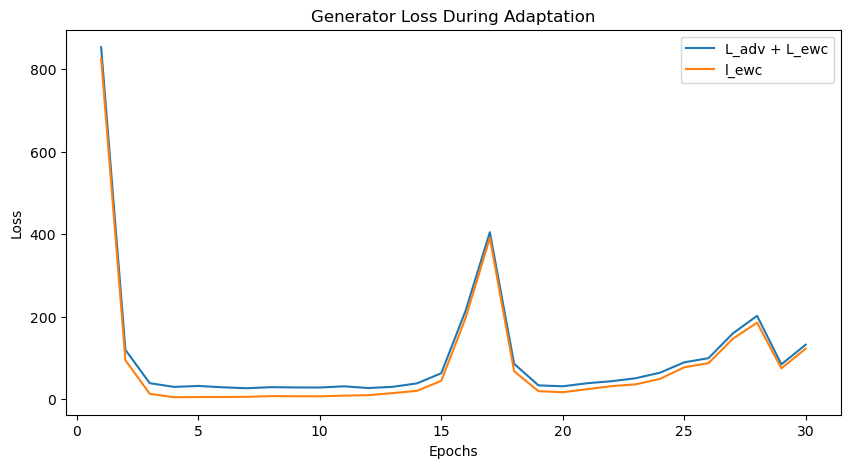

In [9]:
for epoch in range(num_epochs):
    # Visualize the loss 
    print('Epoch : ',f'[{epoch}/{num_epochs}] ')
    make_train_summary_plot(
        [g_history, ewc_history], colors=["tab:blue", "tab:orange"], labels=["L_adv + L_ewc", "l_ewc"]
    )

    avg_loss_d = 0 
    avg_loss_g = 0
    avg_l_ewc = 0
    for i, data in enumerate(tqdm(dataloader)):
        
        real_data = data[0].to(device)
        label = torch.full((batch_size, ), real_lb, dtype=torch.float).to(device)

        #-- Train Generator
        
        # Reset gradients
        adapt_generator.zero_grad()

        # Generate fake data + classification of Discriminator
        noise = torch.randn(batch_size, latent_size).to(device)
        fake_data = adapt_generator(noise)
        output = dis_model(fake_data).view(-1)

        label.fill_(real_lb)

        loss_G_adv = criterion(output, label)
        
        # Compute L_adapt = L_adv + EWC
        loss_G, l_ewc = loss_adapt(loss_G_adv, ewc, adapt_generator, batch_size=batch_size, weight=regWeight)

        avg_loss_g += loss_G
        avg_l_ewc += l_ewc

        # Optimize step
        loss_G.backward()
        optimizer_g_adapt.step()

    avg_loss_g /= len(dataloader)
    avg_l_ewc /= len(dataloader)
    g_history.append(avg_loss_g.detach().cpu().numpy())
    ewc_history.append(avg_l_ewc.detach().cpu().numpy())

    if epoch != num_epochs:
        clear_output()

    print(f'Loss_G: {avg_loss_g.item():.4f}, EWC: {avg_l_ewc.item()}')
    
    # Checkpoint
    # if (epoch % 5 == 0):
    #     plt_save_path = f"plts/gan_train_{epoch}.png"
    #     make_image_plot(plt_save_path, adapt_generator)
    #     torch.save(adapt_generator.state_dict(), 'models/generator_adapt_epoch%d.pth' %epoch)
        

make_train_summary_plot(
    [g_history, ewc_history], colors=["tab:blue", "tab:orange"], labels=["L_adv + L_ewc", "l_ewc"]
)

## **Calculate & plot parameter difference**

Text(0, 0.5, 'Mean Squared Difference')

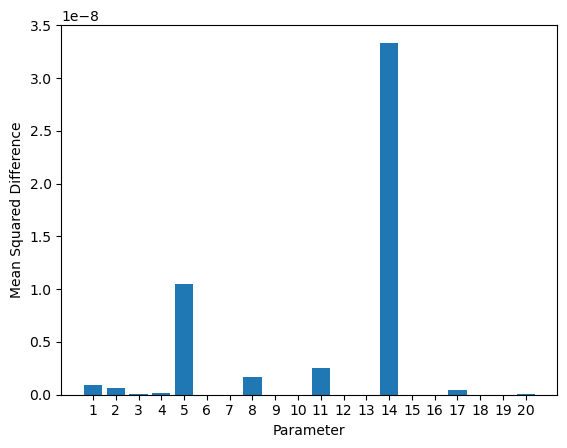

In [10]:
dparams = param_diff(adapt_generator, gen_model)
plt.bar(np.arange(len(dparams)) + 1, dparams)
plt.xticks(np.arange(len(dparams)) + 1)
plt.xlabel("Parameter")
plt.ylabel("Mean Squared Difference")

In [11]:
generate_folder(adapt_generator, folderpath="generated/adapted", examples=200)
generate_folder(gen_model, folderpath="generated/preadapt", examples=200)